### Working with distributed data

Let's see how to make some Data analisys on distributed dataset

In [1]:
from dask.distributed import Client
client = Client() #Client('dask-scheduler:8786')
client

Client Scheduler: tcp://127.0.0.1:53181 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 7.92 GB


Let's create a random timeseries dataset with the following attributes:

+ It stores a record for every 10 seconds of the year 2000

+ It splits that year by month, keeping every month as a separate Pandas dataframe

+ Along with a datetime index it has columns for names, ids, and numeric values

This is a small dataset of about 480 MB. Increase the number of days or reduce the frequency to practice with a larger dataset.

In [2]:
import dask
import dask.dataframe as dd
df = dask.datasets.timeseries(start='2019-03-01', end='2019-04-30')

In [3]:
df

,id,name,x,y
npartitions=60,,,,
2019-03-01,int32,object,float64,float64
2019-03-02,...,...,...,...
...,...,...,...,...
2019-04-29,...,...,...,...
2019-04-30,...,...,...,...


In [4]:
df.dtypes

id        int32
name     object
x       float64
y       float64
dtype: object

In [5]:
import pandas as pd
pd.options.display.precision = 2
pd.options.display.max_rows = 10

In [6]:
df.head(3)

,id,name,x,y
timestamp,,,,
2019-03-01 00:00:00,1038,Tim,-0.24,0.69
2019-03-01 00:00:01,979,Patricia,0.83,-0.82
2019-03-01 00:00:02,1006,Victor,-0.69,-0.47


In [7]:
df2 = df[df.y > 0]
df3 = df2.groupby('name').x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 311 tasks

In [8]:
computed_df = df3.compute()
type(computed_df)

pandas.core.series.Series

In [9]:
computed_df

name
Alice      0.58
Bob        0.58
Charlie    0.58
Dan        0.58
Edith      0.58
           ... 
Victor     0.58
Wendy      0.58
Xavier     0.58
Yvonne     0.58
Zelda      0.58
Name: x, Length: 26, dtype: float64

### Persist data in memory
If you have the available RAM for your dataset then you can persist data in memory.

This allows future computations to be much faster.



In [ ]:
df = df.persist()

### Time Series Operations
Because we have a datetime index time-series operations work efficiently

In [12]:
%matplotlib inline

df[['x', 'y']].resample('1h').mean().head()

,x,y
timestamp,,
2019-03-01 00:00:00,6.34e-03,-1.51e-03
2019-03-01 01:00:00,-4.73e-03,-3.34e-04
2019-03-01 02:00:00,-7.36e-04,-2.22e-03
2019-03-01 03:00:00,-4.59e-03,-6.98e-03
2019-03-01 04:00:00,6.45e-03,-7.33e-04


<AxesSubplot:xlabel='timestamp'>

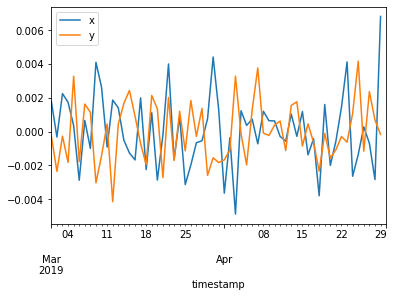

In [13]:
df[['x', 'y']].resample('24h').mean().compute().plot()

In [14]:
df[['x', 'y']].rolling(window='24h').mean().head()

,x,y
timestamp,,
2019-03-01 00:00:00,-0.24,0.69
2019-03-01 00:00:01,0.29,-0.06
2019-03-01 00:00:02,-0.04,-0.20
2019-03-01 00:00:03,0.08,-0.28
2019-03-01 00:00:04,-0.08,-0.16


In [15]:
df.loc['2019-04-05']

,id,name,x,y
npartitions=1,,,,
2019-04-05 00:00:00.000000000,int32,object,float64,float64
2019-04-05 23:59:59.999999999,...,...,...,...


In [16]:
%time df.loc['2019-04-05'].compute()

Wall time: 62 ms


,id,name,x,y
timestamp,,,,
2019-04-05 00:00:00,1014,Victor,-0.19,-0.67
2019-04-05 00:00:01,974,Zelda,-0.84,0.59
2019-04-05 00:00:02,961,Oliver,0.80,0.68
2019-04-05 00:00:03,1002,Laura,0.61,0.32
2019-04-05 00:00:04,1026,Yvonne,0.62,-0.01
...,...,...,...,...
2019-04-05 23:59:55,1014,Michael,-0.85,-0.05
2019-04-05 23:59:56,981,Kevin,0.40,-0.40
2019-04-05 23:59:57,990,Ingrid,-0.19,0.16


### Set Index
Data is sorted by the index column. 
This allows for faster access, joins, groupby-apply operations, etc.. However sorting data can be costly to do in parallel, so setting the index is both important to do, but only infrequently.

In [17]:
df = df.set_index('name')
df

,id,x,y
npartitions=60,,,
Alice,int32,float64,float64
Alice,...,...,...
...,...,...,...
Zelda,...,...,...
Zelda,...,...,...


Again, because computing this dataset is expensive and we can fit it in our available RAM, we persist the dataset to memory.

In [18]:
df = df.persist()

Dask now knows where all data lives, indexed cleanly by name. 
As a result operations like random access are cheap and efficient

In [19]:
%time df.loc['Alice'].compute()

Wall time: 2.32 s


,id,x,y
name,,,
Alice,977,0.12,0.94
Alice,1002,0.48,-0.47
Alice,965,0.49,-0.62
Alice,960,-0.90,-0.57
Alice,956,0.94,0.51
...,...,...,...
Alice,974,0.12,-0.07
Alice,984,0.36,0.11
Alice,1004,0.72,0.83


### Groupby-Apply a simple way to work on large datasets
Now that our data is sorted by name we can easily do operations like random access on name, or groupby-apply with custom functions.

Here we train a different Scikit-Learn linear regression model on each name.

In [20]:
from  sklearn.linear_model import LinearRegression

def train(partition):
    est = LinearRegression()
    est.fit(partition[['x']].values, partition.y.values)
    return est

df.groupby('name').apply(train, meta=object).compute()

name
Alice      LinearRegression()
Bob        LinearRegression()
Charlie    LinearRegression()
Dan        LinearRegression()
Edith      LinearRegression()
                  ...        
Victor     LinearRegression()
Wendy      LinearRegression()
Xavier     LinearRegression()
Yvonne     LinearRegression()
Zelda      LinearRegression()
Length: 26, dtype: object

In [22]:
client.close()